In [ ]:
pip install pandas_profiling

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas_profiling
import warnings

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import recall_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')


sns.set_theme(style="white")

In [19]:
df = pd.read_csv('SDSS.csv')

In [36]:
df

,r_ascension,declination,uv,g_band,r_band,infra,n_infra,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590
...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0.027583
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0.117772
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,-0.000402
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0.014019


In [ ]:
df.info()

## Exploratory Data Analysis

We first check if there are any NaN values to be accounted for. In this case there aren't

In [4]:
df.isna().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

This function is used to help determine correlation above a set threshold

In [21]:
def high_corr(df, alpha = 0.7):
    corr = df[[cor for cor in df.columns if cor != 'class']].corr()

    corr_tuples = [(f, list(s[abs(s) > alpha].index)) for f,s in corr.iteritems()]

    for t1, t2 in corr_tuples:
        if t1 in t2:
            t2.remove(t1)

    corr_f = [t for t in corr_tuples if len(t[1]) != 0]

    highly_corr = []
    for t in corr_f:
        for f in t[1]:
            highly_corr.append(f)

    return list(set(highly_corr))

Here are some of the features that have a correlation greater than 0.7

In [22]:
high_corr(df)

['r', 'mjd', 'i', 'specobjid', 'g', 'run', 'u', 'z', 'dec', 'plate']

In [ ]:
sns.relplot(x = 'g', y = 'u', hue = 'class', data = df)

In [ ]:
df.columns

We are taking the classification of the element in space and creating a separate variable for them

In [23]:
space_class = df['class']

turning the classes into numbers

In [24]:
space_class.replace({"STAR": 1, "GALAXY": 2, "QSO": 3}, inplace=True)

Droping Columns that we don't need

In [25]:
df.drop(['run', 'rerun', 'class', 'camcol', 'field', 'objid', 'specobjid', 'fiberid', 'plate', 'mjd'], axis = 1, inplace= True)

Renaming the remaining columns

In [26]:
df.rename(columns={'ra': 'r_ascension', 'dec': 'declination', 'u': 'uv', 'g': 'g_band', 'r': 'r_band', 'i': 'infra', 'z': 'n_infra'}, inplace = True)

Doing a train-test-split on the data

In [46]:
data_train, data_test, target_train, target_test = train_test_split(df, space_class, test_size = 0.2, random_state = 42)


# Logistic Regression

In [47]:
# Instantiate a Logistic Regression Model (liblinear is recommende for small datasets)
logreg = LogisticRegression(C=1e5, solver='liblinear')

# fit the model 
logreg_model = logreg.fit(df,space_class)

In [48]:
coef = logreg_model.coef_
interc = logreg_model.intercept_

In [49]:
log_train_pred = logreg.predict(data_train)
log_test_pred = logreg.predict(data_test)

# Decision Tree Regression

In [50]:
dtree_c = DecisionTreeRegressor(max_depth = 2) 
dtree_c.fit(data_train, target_train)

DecisionTreeRegressor(max_depth=2)

In [51]:
d_tree_pred = dtree_c.predict(data_test)

In [74]:
d_tree_pred = np.round(d_tree_pred)

# Random Forest Regression

In [52]:
jungle = RandomForestRegressor(n_estimators=100, max_depth= 5)
jungle.fit(data_train, target_train)

RandomForestRegressor(max_depth=5)

# Bagging Regression

In [53]:
bagged_tree =  BaggingRegressor(DecisionTreeRegressor(max_depth=5), 
                                 n_estimators=20, n_jobs = -1, oob_score=True, verbose= 1)

In [54]:
bagged_tree.fit(data_train, target_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.1s finished


BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5),
                 n_estimators=20, n_jobs=-1, oob_score=True, verbose=1)

# Results

In [76]:
print ("\nClassification report Logisitic Regression:\n",(classification_report(target_test, test_pred)))

print ("\nClassification report Decision Tree Regression:\n",(classification_report(target_test, d_tree_pred)))

print ("\nClassification report Random Forest Regression Train:\n", (jungle.score(data_train, target_train))) 

print ("\nClassification report Random Forest Regression Test:\n", (jungle.score(data_test, target_test))) 

print ("\nClassification report Bagging Regression Train:\n", (bagged_tree.score(data_train, target_train)))

print ("\nClassification report Bagging Regression Test:\n", (bagged_tree.score(data_test, target_test)))


Classification report Logisitic Regression:
               precision    recall  f1-score   support

           1       0.95      0.99      0.97       814
           2       0.97      0.95      0.96       996
           3       0.97      0.91      0.94       190

    accuracy                           0.96      2000
   macro avg       0.96      0.95      0.96      2000
weighted avg       0.96      0.96      0.96      2000


Classification report Decision Tree Regression:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99       814
           2       0.98      0.99      0.99       996
           3       0.97      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000


Classification report Random Forest Regression Train:
 0.9828366671263189

Classification report Random Forest Regression Test:
 0.9806902935

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [15]:
cf_matrix_dt = confusion_matrix(target_test, test_pred)
print(cf_matrix_dt)


[[804   8   2]
 [ 45 948   3]
 [  0  17 173]]


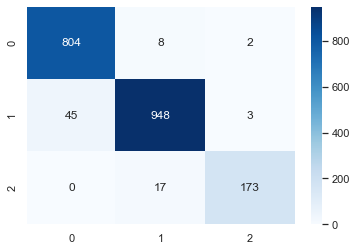

In [16]:
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in
#                 cf_matrix_dt.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_dt.flatten()/np.sum(cf_matrix_dt)]
# labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
# labels = np.asarray(labels).reshape(4,4)
sns.heatmap(cf_matrix_dt, annot=True, fmt='', cmap='Blues');

In [ ]:
sns.pairplot(data = df, palette = 'Dark2', hue = space_class)

In [35]:
df.columns

Index(['r_ascension', 'declination', 'uv', 'g_band', 'r_band', 'infra',
       'n_infra', 'redshift'],
      dtype='object')

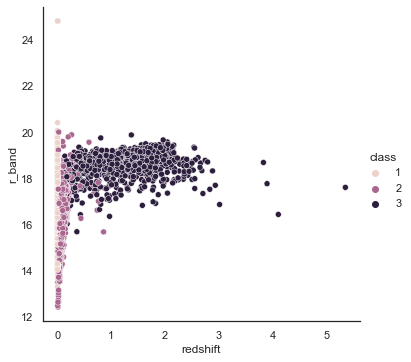

In [39]:
sns.relplot(x = 'redshift', y = 'r_band', hue = space_class, data = df)

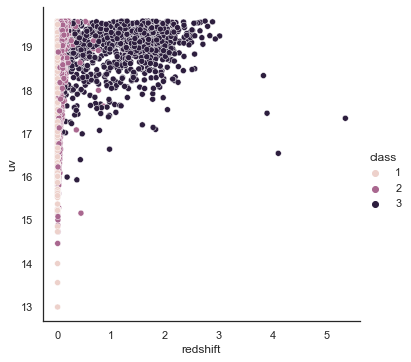

In [40]:
sns.relplot(x = 'redshift', y = 'uv', hue = space_class, data = df)

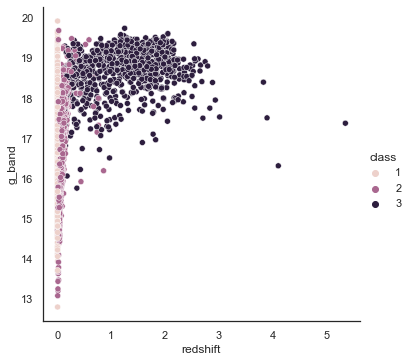

In [41]:
sns.relplot(x = 'redshift', y = 'g_band', hue = space_class, data = df)

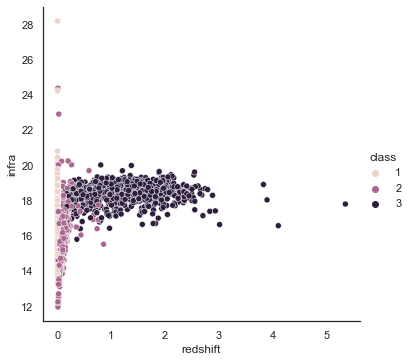

In [42]:
sns.relplot(x = 'redshift', y = 'infra', hue = space_class, data = df)

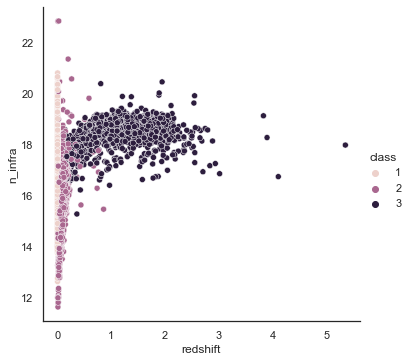

In [38]:
sns.relplot(x = 'redshift', y = 'n_infra', hue = space_class, data = df)

## Start 2

We have a dataframe with columns dropped and renamed

In [ ]:
df

We have a series with the class of the rows

In [ ]:
space_class

We run a basic decision tree regressor over the dataframe with a depth of 2

In [ ]:
dtree_c = DecisionTreeRegressor(max_depth = 2) 
dtree_c.fit(data_train, target_train)

In [ ]:
pred = dtree_c.predict(data_test)

In [ ]:
target_test

In [ ]:
target_test = pd.to_numeric(target_test, downcast="float")

In [ ]:
type(target_test)

In [ ]:
x = np.round(pred)

In [ ]:
type(x[0])

In [ ]:
type(y_test)

In [ ]:
cf_matrix_dt = confusion_matrix(target_test, x)
print(cf_matrix_dt)

In [75]:
#confusion_matrix(y_test, pred)

#print(classification_report(X_test, y_1))
print(classification_report (target_test, d_tree_pred))

#classification_report(y_test, pred.round(), normalize = False)

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       814
           2       0.98      0.99      0.99       996
           3       0.97      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
np.argmax(pred)

We do a feature immportance method and plot the results

In [ ]:
dtree_df.feature_importances_

In [ ]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dtree_df)

## Creating a baseline model: Decision Tree

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df, space_class, random_state=42)

In [34]:
dt_clf = DecisionTreeClassifier()

dt_cv_score = cross_val_score(dt_clf, data_train, target_train, cv=3)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 98.45%


Pretty Good Accuracy for a baseline

## Establishing Random Forest

In [ ]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(data_train, target_train)

In [ ]:
forest.score(data_train, target_train)

In [ ]:
forest.score(data_test, target_test)

In [ ]:
plot_feature_importances(forest)

In [ ]:
jungle = RandomForestRegressor(n_estimators=100, max_depth= 5)
jungle.fit(data_train, target_train)

In [ ]:
jungle.score(data_train, target_train)

In [ ]:
jungle.score(data_test, target_test)

In [ ]:
plot_feature_importances(jungle)

## Creating Bagging Classifiers

In [ ]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20, n_jobs = -1, oob_score=True, verbose= 1)

In [ ]:
bagged_tree.fit(data_train, target_train)

In [ ]:
bagged_tree.score(data_train, target_train)

In [ ]:
bagged_tree.score(data_test, target_test)